# Multimodality Attention module

## Helper function

In [1]:
## Helper function

%cd "~/projects/spartDM"
%load_ext autoreload
%autoreload 2

import os

print(f"Current working dir: {os.getcwd()}")

import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
from einops import rearrange

import torchvision
from functools import partial
from src.utils.visualization import plot_comparison_starmen, plot_kde_pixel, draw_featmap
from src.ldae.utils import heat_map, feature_distance, patchify
from skimage.filters import threshold_yen, threshold_otsu

# Helper function to quick plot a tensor using torchvision grid
def quick_plot_tensor(x, title, normalize=True):
    """
    x: torch.tensor of size(B, C, H, W)
    """
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    grid = torchvision.utils.make_grid(x, nrow=10, normalize=normalize, padding=1)  # noqa: F821
    plt.figure(figsize=(16, 4))  
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(title)
    plt.axis("off")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_torch = partial(torch.tensor, dtype=torch.float32, device=device)


DATA_DIR = "data/starmen/output_random_noacc"
WORK_DIR = "workdir/diffae_starmen"

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/kdang/projects/spartDM
Current working dir: /home/kdang/projects/spartDM


/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


## Load spatial Diffusion Model

In [2]:
# CondDDPM model

from src.ldae import CondDDPM
from lightning.pytorch.utilities.model_summary import ModelSummary


## Load model
ckpt_path = os.path.join(WORK_DIR, "representation-learning", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sdm_litmodel = CondDDPM.load_from_checkpoint(ckpt_path, map_location=device)

# Model summary

summary = ModelSummary(sdm_litmodel, max_depth=1)
print(summary)

Backbone model loaded successfully.
Frozen first 0 layers out of 161 in the backbone

  | Name        | Type            | Params | Mode 
--------------------------------------------------------
0 | decoder     | CondUNet        | 2.5 M  | train
1 | encoder     | SemanticEncoder | 24.6 M | train
2 | ema_encoder | SemanticEncoder | 24.6 M | eval 
3 | ema_decoder | CondUNet        | 2.5 M  | eval 
--------------------------------------------------------
27.1 M    Trainable params
27.1 M    Non-trainable params
54.1 M    Total params
216.547   Total estimated model params size (MB)
492       Modules in train mode
492       Modules in eval mode


## Load temporal diffusion model

In [3]:
from src.ldae import TADMLitModel

tadm_ckpt_path = os.path.join(WORK_DIR, "tadm", "checkpoints", "last.ckpt")

ckpt = torch.load(tadm_ckpt_path, map_location=device)

tadm_litmodel = TADMLitModel.load_from_checkpoint(tadm_ckpt_path, map_location=device)

print(ModelSummary(tadm_litmodel, max_depth=1))

  | Name        | Type     | Params | Mode 
-------------------------------------------------
0 | encoder     | RRDBNet  | 5.9 M  | train
1 | decoder     | TADMUnet | 2.4 M  | train
2 | ema_encoder | RRDBNet  | 5.9 M  | eval 
3 | ema_decoder | TADMUnet | 2.4 M  | eval 
-------------------------------------------------
8.3 M     Trainable params
8.3 M     Non-trainable params
16.6 M    Total params
66.462    Total estimated model params size (MB)
614       Modules in train mode
614       Modules in eval mode


## Load FE model

In [4]:
# Fine-tuned feature extractor model

from src.ldae import CondDDPM, FeatureExtractorLitmodel
from lightning.pytorch.utilities.model_summary import ModelSummary


## Load model
ckpt_path = os.path.join(WORK_DIR, "fe-train", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

diffae_litmodel = FeatureExtractorLitmodel.load_from_checkpoint(ckpt_path, map_location=device)

fe = diffae_litmodel.fe
fe = fe.float()
fe.eval()

# Model summary

summary = ModelSummary(diffae_litmodel, max_depth=1)
print(summary)

Backbone model loaded successfully.
Frozen first 0 layers out of 161 in the backbone

Freeze ema_encoder from DDPM models.
Delete litmodel. Only keep UNet and Encoder
  | Name    | Type             | Params | Mode
----------------------------------------------------
0 | encoder | SemanticEncoder  | 24.6 M | eval
1 | unet    | CondUNet         | 2.5 M  | eval
2 | fe      | FeatureExtractor | 17.1 M | eval
----------------------------------------------------
8.5 M     Trainable params
27.1 M    Non-trainable params
35.6 M    Total params
142.422   Total estimated model params size (MB)
0         Modules in train mode
615       Modules in eval mode


## DataLoader

In [5]:
from src.data.datamodules import StarmenDataset
from monai.data import DataLoader
from monai.data.utils import first

train_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="train",
    nb_subject=None,
)

test_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="test",
    nb_subject=None,
)

growing_circle_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="growing_circle20",
    nb_subject=None,
)

train_loader = DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=1)

one_batch = first(iter(train_loader))

test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)

growing_circle_loader = DataLoader(growing_circle_ds, batch_size=1, shuffle=True, num_workers=1)

### Reconstruction files from SDM

In [6]:
# Reload the data 
import json

split = "growing_circle20"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

# Test dataset
test_ds = StarmenDataset(
    data_dir=DATA_DIR,
    split=split,
    nb_subject=None,
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)
print(f"Len of test dataset: {len(test_loader)}")


# Read the reconstruction error files to get the index and corresponding reonconstruction image
try: 
    eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
    with open(eval_result_file, "r") as f:
        eval_dict = json.load(f)
    test_ids = eval_dict["IDs"]
    # test_ids = np.load(recons_idx_path)
    # test_ids = test_ids.squeeze().tolist()
except FileNotFoundError:
    test_ids = test_ds.ids

test_ids

# Load the original (anomalious) image from test dataset by index
x_orgs = [test_ds.get_images_by_id(id)["img"].squeeze() for id in test_ids]
x_orgs = np.stack(x_orgs).astype("float32")

# Load the groundtruth anomaly mask 
x_ano_gts = []
for id in test_ds.ids:
    x_ano_gt = test_ds.get_images_by_id(id)["anomaly_gt_seg"]

    if x_ano_gt is None:
        break
    else:
        x_ano_gts.append(x_ano_gt.squeeze())

if len(x_ano_gts) > 0: 
    x_ano_gts = np.stack(x_ano_gts).astype("float32")
x_ano_gts.shape

# Load the original healthy images
# healthy path example= data/starmen/output_random_noacc/images/SimulatedData__Reconstruction__starman__subject_s0__tp_0.npy
x_hts = []
for id in test_ids:
    for t in range(0, 10):
        ht_path = os.path.join(DATA_DIR, "images", f"SimulatedData__Reconstruction__starman__subject_s{id}__tp_{t}.npy")
        ht = np.load(ht_path)
        x_hts.append(ht)
x_hts = np.stack(x_hts)
x_hts = rearrange(x_hts, "(b t) h w -> b t h w", t=10)
x_hts.shape

# add C dimension
x_orgs = rearrange(x_orgs, "b t h w -> b t 1 h w")
x_ano_gts = rearrange(x_ano_gts, "b t h w -> b t 1 h w")
x_hts = rearrange(x_hts, "b t h w -> b t 1 h w")

# # Load reconstruction - xT_inferred
# x_recons = np.load(os.path.join(infer_dir, "results", "recons.npy"))
# x_recons.shape

# Load reconstruction - from random noise
x_recons = np.load(os.path.join(infer_dir, "results", "recons_semantic.npy"))
x_recons.shape

# convert to torch

x_orgs = to_torch(x_orgs) if not isinstance(x_orgs, torch.Tensor) else x_orgs
x_hts = to_torch(x_hts) if not isinstance(x_hts, torch.Tensor) else x_hts
x_ano_gts = to_torch(x_ano_gts) if not isinstance(x_ano_gts, torch.Tensor) else x_ano_gts
x_recons = to_torch(x_recons) if not isinstance(x_recons, torch.Tensor) else x_recons

Len of test dataset: 20


# Test steps

## Load 1 batch of data

In [7]:
print(test_ids)

[210, 332, 822, 989, 868, 481, 892, 901, 896, 947, 907, 377, 280, 382, 583, 208, 67, 800, 761, 797]


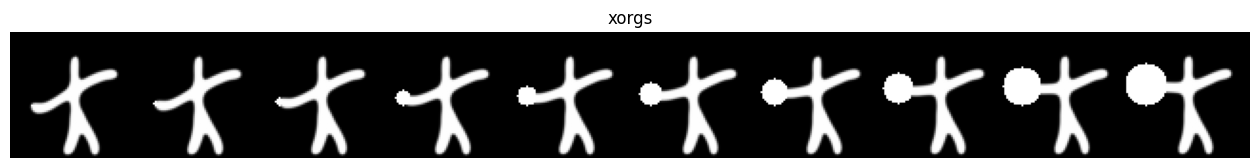

In [8]:
patient_idx = 2
patient_id = test_ids[patient_idx]

x_orgs = x_orgs[patient_idx]
x_hts = x_hts[patient_idx]
x_ano_gts = x_ano_gts[patient_idx]
x_recons = x_recons[patient_idx]

quick_plot_tensor(x_orgs, 'xorgs')


In [9]:

# Get patient meta data from dataloader
out = growing_circle_ds.get_images_by_id(patient_id)
ages = out["age"]
ages = to_torch(ages)

# sanity check
torch.all(to_torch(out["img"]).float() == x_orgs)

print(ages)

tensor([-9.2000, -7.9900, -6.7800, -5.5700, -4.3600, -3.1500, -1.9400, -0.7400,
         0.4700,  1.6800])


## Spatial anomaly detection with SDM 

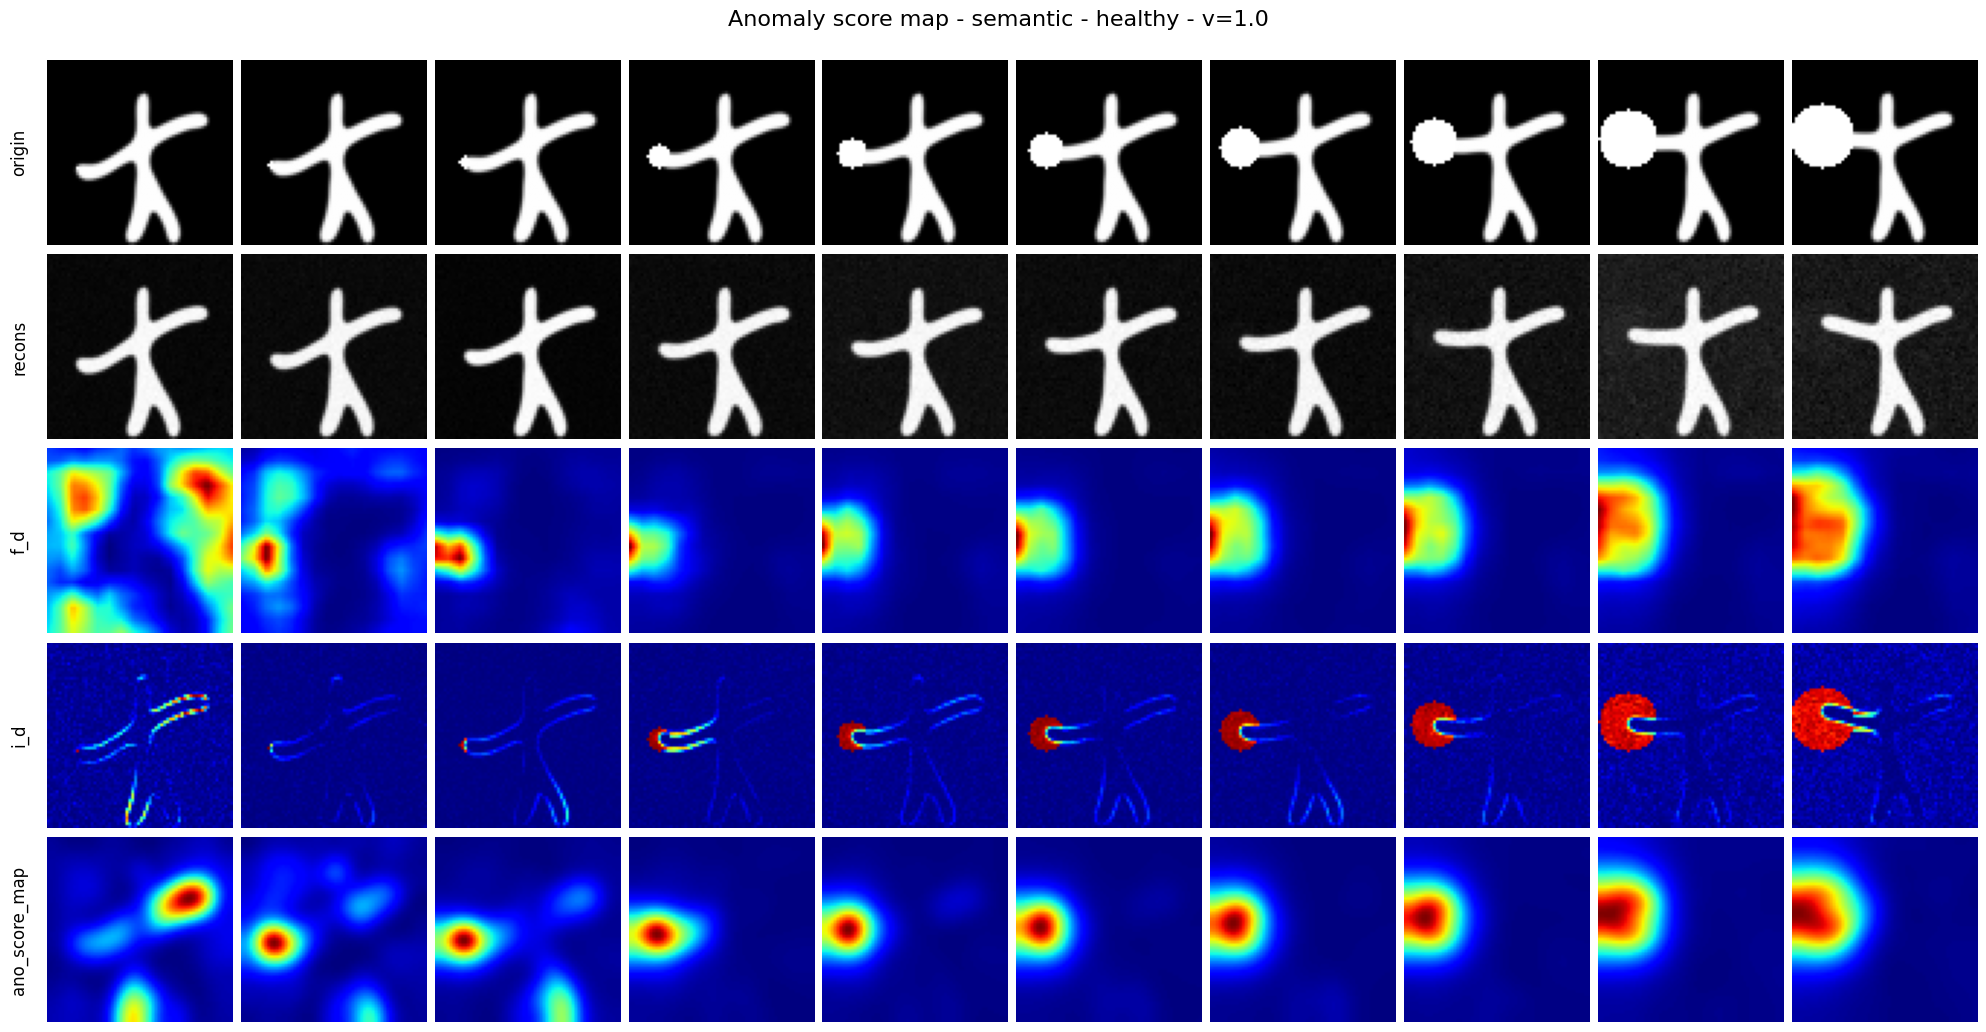

In [40]:
heatmap_v = 1.

ano_map, f_d, i_d = heat_map(
    x_recons, x_orgs, fe, v=heatmap_v, fe_layers=["layer1", "layer2"]
)

# Plot anomaly score map
imgs = [
    x_orgs.detach().cpu().squeeze(),
    x_recons.detach().cpu().squeeze(),
    f_d.detach().cpu().squeeze(),
    i_d.detach().cpu().squeeze(),
    ano_map.detach().cpu().squeeze(),
]

labels = ["origin", "recons", "f_d", "i_d", "ano_score_map"]

title = f"Anomaly score map - semantic - healthy - v={heatmap_v}"
opt = {"title": title}

fig = plot_comparison_starmen(
    imgs,
    labels,
    is_errors=[False, False, True, True, True],
    opt=opt,
    same_cbar=False,
    display_cbar=True,
)

### Post processing

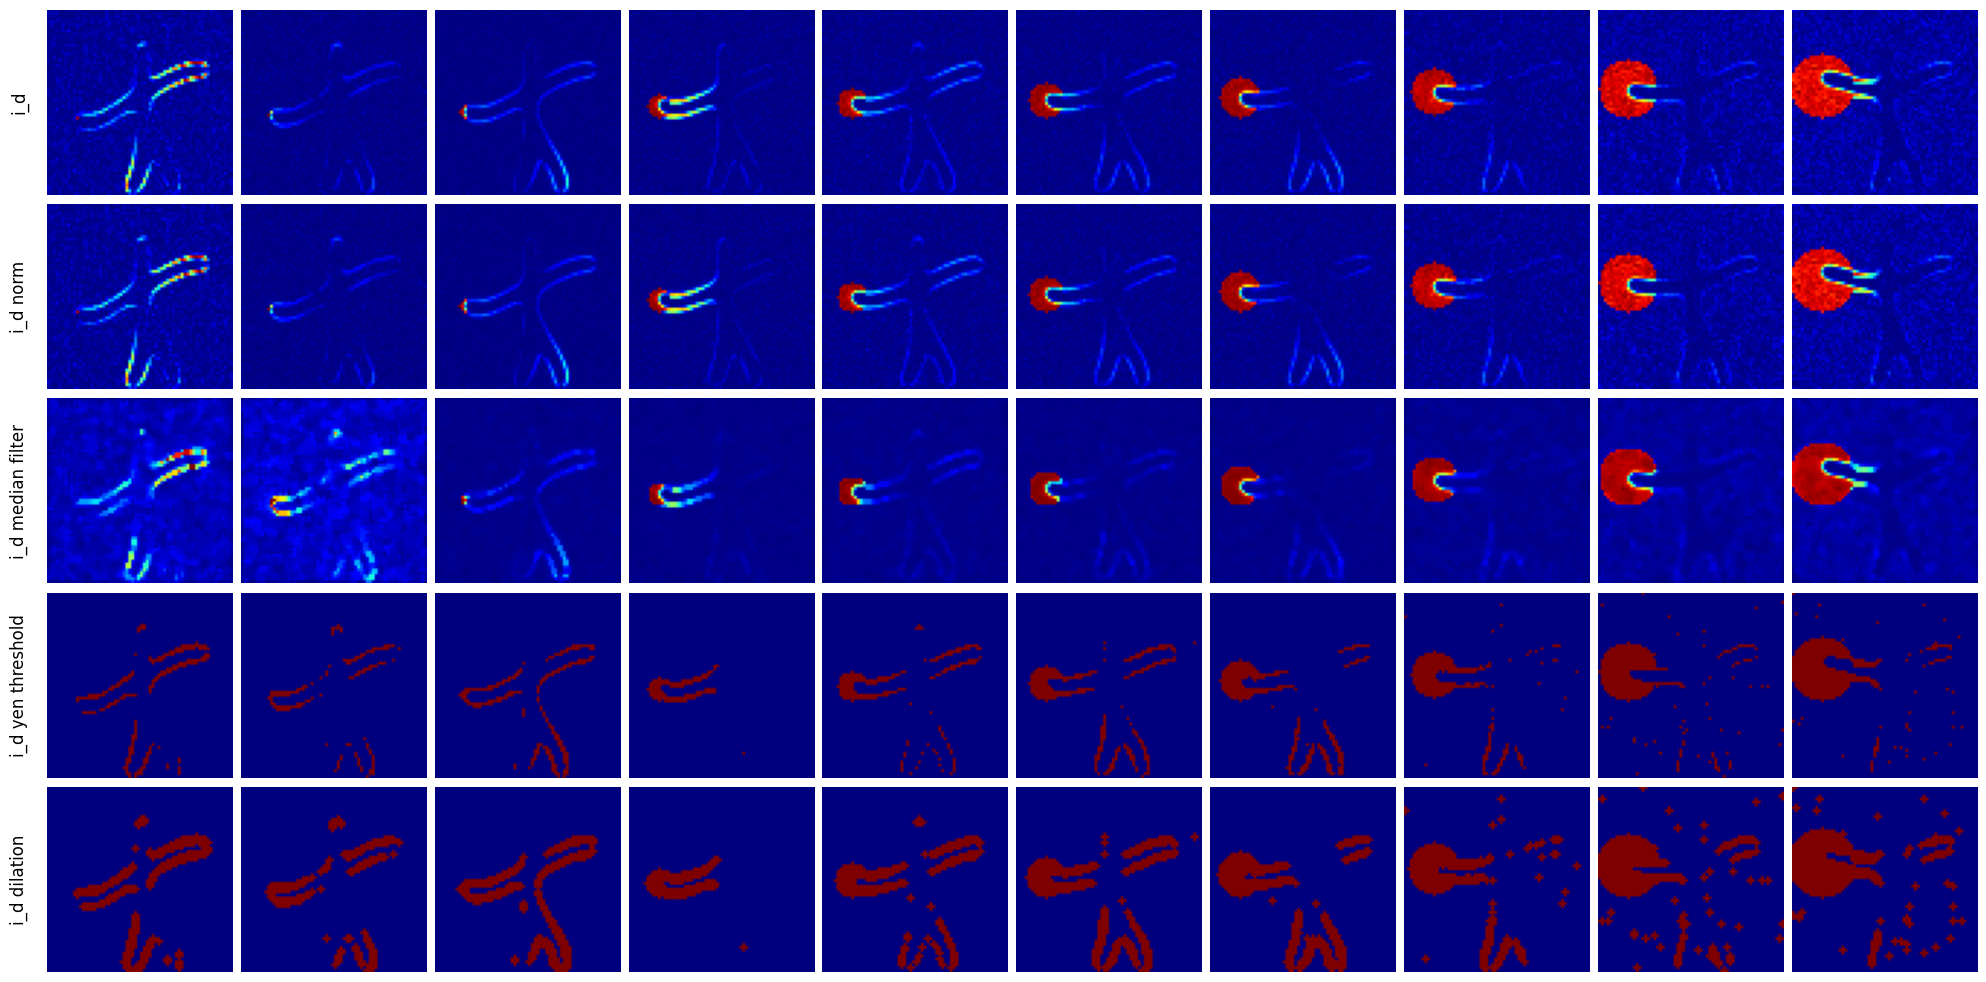

In [52]:
def norm_tensor(tensor):
    my_max = torch.max(tensor)
    my_min = torch.min(tensor)
    my_tensor = (tensor - my_min) / (my_max - my_min)
    return my_tensor

i_d_norm = i_d.clone()
for i in range(i_d.shape[0]):
    i_d_norm[i] = norm_tensor(i_d[i])
i_d_norm.shape

# Median filter
from scipy.signal import medfilt2d
def median_filter_2D(volume, kernelsize=5):
    volume = volume.cpu().numpy()
    volume_mf = np.zeros_like(volume)
    for i in range(len(volume)):
        for j in range(volume.shape[1]):
            volume_mf[i, j, :, :] = medfilt2d(volume[i, j, :, :], kernel_size=kernelsize)
    return torch.Tensor(volume_mf)

i_d_mf = median_filter_2D(i_d, kernelsize=3)


# Yen threshold
from skimage.filters import threshold_yen

i_d_yen_seg = torch.zeros_like(i_d)

for i in range(i_d_mf.shape[0]):
    thr = threshold_yen(i_d[i].numpy())
    i_d_yen_seg[i] = torch.where(i_d[i] > thr, 1.0, 0.0)

# Binary structure
from scipy.ndimage import generate_binary_structure
from scipy.ndimage import binary_dilation
def bin_dilation(volume, structure):
    volume_dil = volume.clone().cpu().numpy()
    volume = volume.cpu().numpy()
    for i in range(len(volume)):
        volume_dil[i] = binary_dilation(volume[i], structure=structure)
    return torch.Tensor(volume_dil)
rank = 2  # binary dilation rank for yen
connectivity = 1  # binary dilation connectivity for yen

struc = generate_binary_structure(rank, connectivity)
struc

i_d_dilation = bin_dilation(i_d_yen_seg.squeeze(), struc)
i_d_dilation.shape


# Plot
fig = plot_comparison_starmen(
    imgs=[i_d.squeeze(),
          i_d_norm.squeeze(), 
          i_d_mf.squeeze(),
          i_d_yen_seg.squeeze(),
          i_d_dilation],
    labels=["i_d", "i_d norm", "i_d median filter", "i_d yen threshold", "i_d dilation"],
    is_errors=[True, True, True, True, True],
    same_cbar=False
)


## Temporal prediction of future scan

In [11]:
ages

tensor([-9.2000, -7.9900, -6.7800, -5.5700, -4.3600, -3.1500, -1.9400, -0.7400,
         0.4700,  1.6800])

tensor(-3.1500)


tensor([6.0500, 2.4200])

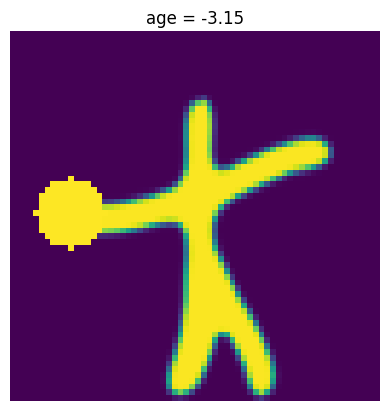

In [12]:
# choose 1 timepoint
time_idx = 5

age = ages[time_idx]
print(age)
x0 = x_orgs[time_idx]
plt.imshow(x0.squeeze())
plt.axis("off")
plt.title(f"age = {age:.2f}")

# Previous images
prev_idx = [0, 3]
prev_ages = ages[prev_idx]
prev_ages

prev_imgs = x_orgs[prev_idx]
prev_imgs.shape

diff_ages = age - prev_ages
diff_ages

In [13]:
# Predict psuedo future scan
tadm_recons = torch.zeros_like(prev_imgs)

with torch.no_grad():
    # 1. encode image with RRDB
    rrdb_out, cond = tadm_litmodel.encoder(prev_imgs, True)

    # 2. Sampling x from trained TADMUnet
    x_pred = tadm_litmodel.gaussian_diffusion.regular_tadm_sample(
        ddim_style="ddim20",
        encoder=tadm_litmodel.encoder,
        unet=tadm_litmodel.decoder,
        x_0=prev_imgs,
        x_T=torch.randn_like(prev_imgs),
        z=cond,
        diff_ages=diff_ages,
        ages=prev_ages,
        disable_tqdm=False,
    )

sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 17.54it/s]


In [14]:
i_d[time_idx].shape

torch.Size([1, 64, 64])

torch.Size([3, 64, 64])

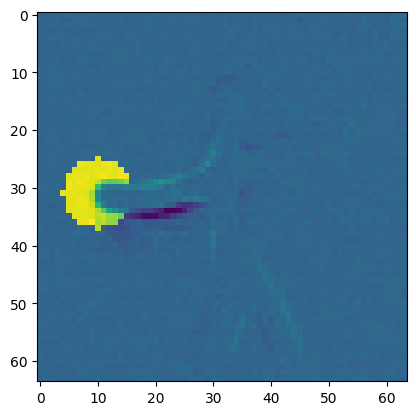

In [15]:
pred_imgs = prev_imgs + x_pred
pred_imgs.shape
pred_diff = x0 - pred_imgs
pred_diff.shape

plt.imshow(pred_diff[0].squeeze())

ano_concat = torch.concat(
    (pred_diff, i_d[time_idx].unsqueeze(0)), 
    dim=0
).squeeze()

ano_concat.shape

## MAF combination

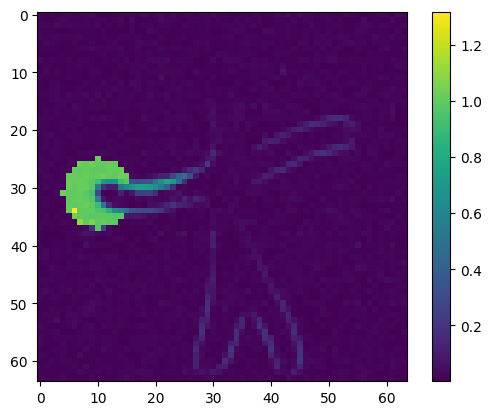

In [20]:
maxv = torch.max(ano_concat, dim=0)[0]
meanv = torch.mean(ano_concat, dim=0)
fv = f_d[time_idx].squeeze()



# anomaly_map = 0.0 * maxv + 1. * meanv + 0.5 * ano_map[time_idx].squeeze()
anomaly_map = 1. * maxv + 0. * meanv 

plt.imshow(anomaly_map)
plt.colorbar()

## Yen threshold

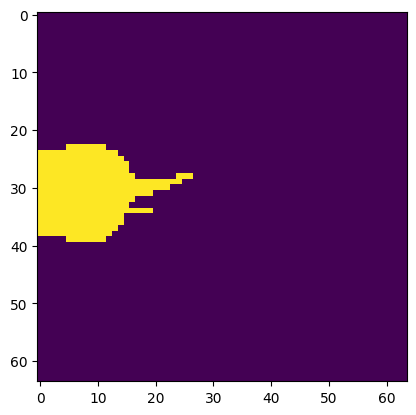

In [111]:
from skimage.filters import threshold_yen

anomaly_map.shape
yen_segmentation = torch.zeros_like(anomaly_map)


thr = threshold_yen(anomaly_map.numpy())
segmentation = torch.where(anomaly_map > thr, 1.0, 0.0)

plt.imshow(segmentation)